In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from IPython.display import HTML
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import SVG
from sklearn.metrics import precision_recall_fscore_support, precision_score, recall_score
from sklearn.metrics import accuracy_score

In [159]:
X_train = pd.read_csv('transformed_data/X_train.csv')
y_train = pd.read_csv('transformed_data/y_train.csv')
X_test = pd.read_csv('transformed_data/X_test.csv')
y_test = pd.read_csv('transformed_data/y_test.csv')
feature_names = X_train.columns.values.tolist()

In [160]:
clf = tree.DecisionTreeClassifier(max_depth=4)
clf = clf.fit(X_train, y_train)

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))
# tree.plot_tree(clf)

0.9199689199689199
0.9125955466932536


In [161]:
# path = tree.DecisionTreeClassifier().cost_complexity_pruning_path(X_train, y_train)
# alphas = path.ccp_alphas
# clfs = []
#
# for alpha in alphas:
#     clf = tree.DecisionTreeClassifier(ccp_alpha=alpha)
#     clf.fit(X_train, y_train)
#     clfs.append(clf)
#
# train_scores = [clf.score(X_train, y_train) for clf in clfs]
# test_scores = [clf.score(X_test, y_test) for clf in clfs]
#
# index_best_model = np.argmax(test_scores)
# best_model = clfs[index_best_model]
# # best_model

In [162]:
# cls = tree.DecisionTreeClassifier(max_depth=4, criterion='entropy')
#
# cls.fit(X_train, y_train)
# print(cls.score(X_train, y_train))
# print(cls.score(X_test, y_test))


In [163]:
# graph = Source(export_graphviz(best_model,
#                                out_file=None,
#                                feature_names=feature_names,
#                                filled = True))
#
# display(SVG(graph.pipe(format='svg')))
#
# style = "<style>svg{width:100% !important;height:100% !important;}</style>"
# HTML(style)

In [164]:
# print(best_model.score(X_train, y_train))
# print(best_model.score(X_test, y_test))

In [165]:
# y_train_pred = best_model.predict(X_train)
# y_test_pred = best_model.predict(X_test)
# display(precision_recall_fscore_support(y_train, y_train_pred, average='micro'))
# display(precision_recall_fscore_support(y_test, y_test_pred, average='micro'))

In [166]:
oneR_train_data = X_train.copy()
oneR_train_data['warning'] = y_train['warning']
oneR_train_data.head(20)

,QoS,station,code,latitude,longitude,revision,PM10,CO,Pb,C2H3NO5,...,O3,TEMP,NOx,SO2,NH3,CH4,PRES,PM2.5,PAHs,warning
0,0.0,629.0,109.0,41.55815,-73.05150,1.434931e+09,-0.602324,0.780765,0.426021,-0.947941,...,-0.891243,-0.652237,-1.186842,-1.487157,-0.863860,-1.240510,2.346972,-1.096992,-0.056719,1.0
1,4.0,285.0,109.0,47.38093,-122.23484,1.602806e+09,-0.168364,0.132065,1.586367,-0.190703,...,0.335432,-0.288734,-1.299722,0.018517,0.010704,0.605686,0.923165,0.179900,-1.662052,0.0
2,4.0,508.0,28.0,18.20854,-71.10077,1.608768e+09,1.234589,0.446553,-0.274074,1.223296,...,-0.746983,0.494694,0.165213,-0.867356,-0.377205,-1.427969,-0.687550,-0.332011,-0.780226,0.0
3,4.0,598.0,33.0,42.06166,-1.60452,1.547770e+09,1.027158,-0.204123,-0.794736,1.006748,...,-1.551678,1.048839,0.395919,-0.030805,0.877335,-0.903050,0.222156,-1.863832,-1.471496,0.0
4,4.0,241.0,109.0,42.16808,-88.42814,1.568938e+09,-0.736870,0.393902,0.920536,-0.939553,...,1.198464,-0.184199,-0.817130,2.143454,1.096679,1.054668,-1.006129,-0.386513,-1.188109,1.0
5,2.0,279.0,109.0,40.65995,-111.99633,1.586736e+09,-1.291805,-1.363419,0.447215,-1.429610,...,0.305192,0.061032,-1.059972,-0.743433,0.424807,0.579395,-0.180417,-0.800231,-0.254873,1.0
6,3.0,103.0,52.0,37.49223,15.07041,1.499472e+09,-0.066345,1.051059,-1.755340,-0.075938,...,0.655718,0.927468,1.338372,1.225825,0.147336,0.792701,-1.176695,0.740308,-1.031927,0.0
7,1.0,471.0,50.0,33.37526,74.30920,1.445472e+09,-0.226076,-0.798301,-1.216601,-0.134007,...,1.016954,0.099154,1.974043,0.287200,0.656267,0.388838,0.247450,1.142375,-0.531006,1.0
8,4.0,643.0,104.0,40.98894,28.67582,1.564618e+09,-1.252469,-1.029276,1.378591,-1.677591,...,-1.006560,-0.138010,2.234758,-0.666410,-0.464185,-0.751293,-0.128990,1.114050,1.520313,1.0
9,4.0,428.0,20.0,-30.60106,-71.19901,1.617840e+09,0.377803,0.875150,0.671654,0.406374,...,0.776961,0.026562,-0.269511,1.219988,0.337536,-0.879094,0.141990,0.657310,1.478017,1.0


In [167]:
def get_predictor_value(dataframe, column):
    split = (dataframe[column][dataframe['warning'] == 0].mean() + dataframe[column][dataframe['warning'] == 1].mean())/2
    group = dataframe[dataframe[column] > split].groupby('warning').size()
    if group[0] > group[1]:
        left = 1
        right = 0
    else:
        left = 0
        right = 1

    return split, left, right

def oneR(train_data, column, data):
    train_data.loc[train_data[column] < data[0], 't'] = data[1]
    train_data.loc[train_data[column] >= data[0], 't'] = data[2]
    accuracy = accuracy_score(train_data['warning'], train_data['t'])
    precision = precision_score(train_data['warning'], train_data['t'])
    recall = recall_score(train_data['warning'], train_data['t'])
    total=(accuracy + precision + recall) / 3
    train_data.drop('t', axis=1, inplace=True)
    return [accuracy, precision, recall, total]

best column from oneR: PAHs
total: 0.846356859049155
accuracy: 0.8317238317238317
precision: 0.8882795043672558
recall: 0.8190672410563776


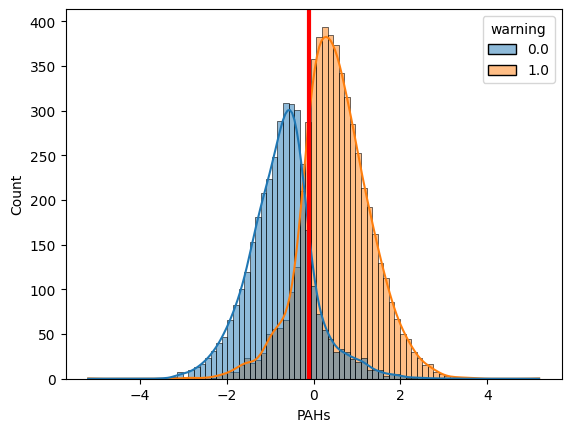

In [168]:
best_accuracy = 0
for column in oneR_train_data.columns:
    if column != 'warning':
        data = get_predictor_value(oneR_train_data, column)
        accuracy_values = oneR(oneR_train_data, column, data)
        if accuracy_values[3] > best_accuracy:
            best_split = data[0]
            best_column = column
            best_accuracy = accuracy_values[3]
            best_column_metrics = accuracy_values

print('best column from oneR: ' + best_column)
print('total: ' + str(best_column_metrics[3]))
print('accuracy: ' + str(best_column_metrics[0]))
print('precision: ' + str(best_column_metrics[1]))
print('recall: ' + str(best_column_metrics[2]))

sns.histplot(data=oneR_train_data, hue='warning', x=best_column, fill=True, kde=True)
plt.axvline(best_split, linewidth=3, color='r')
plt.show()